In [214]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from typing import List, Dict, Tuple
import copy

In [215]:
MAX_DIST = 2147483647
random.seed(100)

In [216]:
def create_distance_matrix(df):
    x = df['x'].values
    y = df['y'].values
    x1 = x.reshape((df.shape[0], 1))
    x2 = x.reshape((1, df.shape[0]))
    y1 = y.reshape((df.shape[0], 1))
    y2 = y.reshape((1, df.shape[0]))
    matrix = np.round(np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)).astype(int)
    np.fill_diagonal(matrix, MAX_DIST)
    return matrix

def evaluate(distance_matrix: np.ndarray, path: np.array, costs: np.array) -> int:
    copy_path = copy.deepcopy(path)
    copy_path = np.append(copy_path, copy_path[0])
    distances = distance_matrix[copy_path[:-1], copy_path[1:]]
    path_costs = costs[copy_path[:-1]]
    total_length = np.sum(distances + path_costs)
    return total_length

def random_sequence(distance_matrix: np.ndarray, start_node: int = 0) -> List[int]:
    n = distance_matrix.shape[0]
    num_selected = n // 2 if n % 2 == 0 else (n // 2) + 1
    path = random.sample(list(range(distance_matrix.shape[0])), num_selected)
    return np.array(path)

In [217]:
def nearest_neighbor(distance_matrix: np.ndarray, costs, start_node: int = 0) -> List[int]:
    n = distance_matrix.shape[0]
    num_selected = n // 2 if n % 2 == 0 else (n // 2) + 1

    distance_matrix_copy = distance_matrix.copy()

    current_node_index = start_node

    for index in range(distance_matrix.shape[0]):
        distance_matrix_copy[index, index] = MAX_DIST

    path = [current_node_index]

    while len(path) < num_selected:

        current_node_distances = distance_matrix_copy[current_node_index, :]

        total_scores = current_node_distances + costs
        closest_node_index = np.argmin(total_scores)

        distance_matrix_copy[current_node_index, :] = MAX_DIST
        distance_matrix_copy[:, current_node_index] = MAX_DIST

        path.append(closest_node_index)
        current_node_index = closest_node_index

    return np.array(path)

In [218]:
def greedy_cycle(D, costs, start_node):
    path = [start_node]
    target_length = math.ceil(len(D) / 2)
    while len(path) < target_length:
        closest_node = 0
        best_increase = MAX_DIST
        free_nodes = [x for x in range(D.shape[0]) if x not in path]
        for idx in range(len(path)):
            for new_node in free_nodes:
                if idx == 0:
                    prev_node = path[-1]
                    next_node = path[0]
                else:
                    prev_node = path[idx - 1]
                    next_node = path[idx]
                curr_increase = (
                    D[prev_node, new_node]
                    + D[new_node, next_node]
                    - D[prev_node, next_node]
                    + costs[new_node]
                )
                if curr_increase < best_increase:
                    best_increase = curr_increase
                    closest_node = new_node
                    node_pos = idx
        path.insert(node_pos, closest_node)
    return np.array(path)

In [219]:
df = pd.read_csv('TSPA.csv', header=None, sep=';', names=['x', 'y', 'cost'])
costs = df['cost'].values
df.shape[0]
distance_matrix = create_distance_matrix(df)

In [220]:
def greedy_regret(D, costs, start_node, weights=1):
    best_neighbour = np.argmin(D[start_node, :] + costs)
    path = [start_node, best_neighbour, start_node]
    target_length = math.ceil(len(D) / 2)
    nodes_available = [x for x in list(range(D.shape[0])) if x not in path]
    edges = [[path[0], path[1]], [path[1], path[2]]]
    while len(path) < target_length+1:
        M = np.zeros((len(nodes_available), len(edges)))
        indices = np.array(nodes_available)
        for edge_ix in range(len(edges)):
            a, b = edges[edge_ix]
            var = D[a, :] + D[:, b] - D[a, b] + costs
            M[:,edge_ix] = var[indices]
        best_score = -MAX_DIST
        replaced_edge = 0
        best_node = 0
        for node_idx in range(len(nodes_available)):
            best, second_best = np.partition(M[node_idx], 1)[:2]
            regret = second_best - best
            score = weights * regret - (1 - weights) * np.min(M[node_idx])
            if score > best_score:
                best_score = score
                replaced_edge = np.argmin(M[node_idx])
                best_node = nodes_available[node_idx]
        path.insert(replaced_edge+1, best_node)
        nodes_available.remove(best_node)
        a, b = edges[replaced_edge]
        edges.pop(replaced_edge)
        edges.insert(replaced_edge, [a, best_node])
        edges.insert(replaced_edge + 1, [best_node, b])

    return np.array(path[:-1])

In [221]:
def get_plot_values(nodes : Dict[int, Tuple[int, int, int]], solution: np.array, costs: List[int]) -> Tuple[List[int], List[int], List[int], List[int], List[int]]:
    solution = list(solution) + [list(solution)[0]]
    x_coords = [nodes[node][0] for node in list(nodes.keys())]
    y_coords = [nodes[node][1] for node in list(nodes.keys())]
    path_x_coords = [nodes[node][0] for node in solution]
    path_y_coords = [nodes[node][1] for node in solution]
    new_costs = [(cost/max(costs))*100 for cost in costs]
    min_cost, max_cost = min(costs), max(costs)
    power = 2
    normalized_costs = [((cost - min_cost) / (max_cost - min_cost)) ** power for cost in costs]
    colors = plt.cm.RdBu(normalized_costs)
    return x_coords, y_coords, new_costs, path_x_coords, path_y_coords, colors


In [222]:
def run_experiment(nodes: Dict[int, Tuple[int, int, int]], distance_matrix: np.ndarray, costs: List[int]) -> None:
  function_mapping = {
      # 'random_algorithm' : random_solution,
      # 'nearest_neighbor' : nearest_neighbor,
      # 'greedy_cycle' : greedy_cycle,
      'greedy_regret' : greedy_regret,
      'greedy_regret_weighted': greedy_regret
  }

  fig, axes = plt.subplots(1, len(function_mapping), figsize=(15, 5))
  i = 0
  for function_name in list(function_mapping.keys()):
    function = function_mapping[function_name]
    paths = []
    results = []
    for starting_node in range(200):
        if function_name == 'greedy_regret_weighted':
            path = function(distance_matrix, costs, starting_node, weights=0.5)
        else:
            path = function(distance_matrix, costs, starting_node)
        score = evaluate(distance_matrix, path, costs)
        paths.append(path)
        results.append(score)

    min_objective = min(results)
    best_solution = paths[np.argmin(np.array(results))]
    max_objective = max(results)
    average_objective = sum(results) / len(results)
    print(f'\n{function_name} results:\n')
    print("Max score:", max_objective)
    print("Average score:", average_objective)
    print("Min/Best score:", min_objective)
    print("Selected Nodes:", best_solution)
    x_coords, y_coords, new_costs, path_x_coords, path_y_coords, colors = get_plot_values(nodes, best_solution, costs)
    axes[i].scatter(x_coords, y_coords, color=colors, marker='o', s=new_costs, label='Cities')
    axes[i].plot(path_x_coords, path_y_coords, linestyle='-', marker='o', markersize=0, color='blue', label='Path', alpha=0.7)
    axes[i].set_title(f"Best {function_name} solution")
    i += 1


In [228]:
def get_solution(filename: str) -> None:
  df = pd.read_csv(filename, header=None, sep=';', names=['x', 'y', 'cost'])
  print(f'Instance: {filename}')
  nodes = {}
  costs = np.array(df['cost'].values)
  for idx, row in enumerate(df.values):
      x, y, cost = map(int, row)
      nodes[idx] = (x, y, cost)
  distance_matrix = create_distance_matrix(df)
  run_experiment(nodes, distance_matrix, costs)


Instance: TSPA.csv

greedy_regret results:

Max score: 124764
Average score: 116240.25
Min/Best score: 104829
Selected Nodes: [ 47  53 108  62  93   7  32 131  81 171 104  79  44 144 141  24  45  68
   6  98 190  72 122  42 111  14 168 107  80 124   8 110  95  31  73 112
  51 135  99 134 126 189 109 119 100  26  52 148 106 160 162  11 152 188
   1  41  39 199 150 192 175  60 167  88 161  76 145 151  49  91 114   4
  77  43  50 149   0  19  58 164  34  40 128  84 158 159  59  96  46  82
 185  64  20  71 183  61 142 113  74 138]

greedy_regret_weighted results:

Max score: 78976
Average score: 76341.56
Min/Best score: 74563
Selected Nodes: [ 32 180  81 154 144  87 141   6 156  98  66  24  45 167 101  99 135  51
 112  95 169  31  73  72 190  94  89 111  14  80 124   8  26 106  48  11
 152 130 119 109 189  75   1 177  41 199 150 192 175 153  88 127 186 170
  79 194  21 171 108  15 117  53  22  55 195  36 132 128 145  76 161  91
 121 114   4  77  43  50   0 149  19 178 164 159 143  59 147  

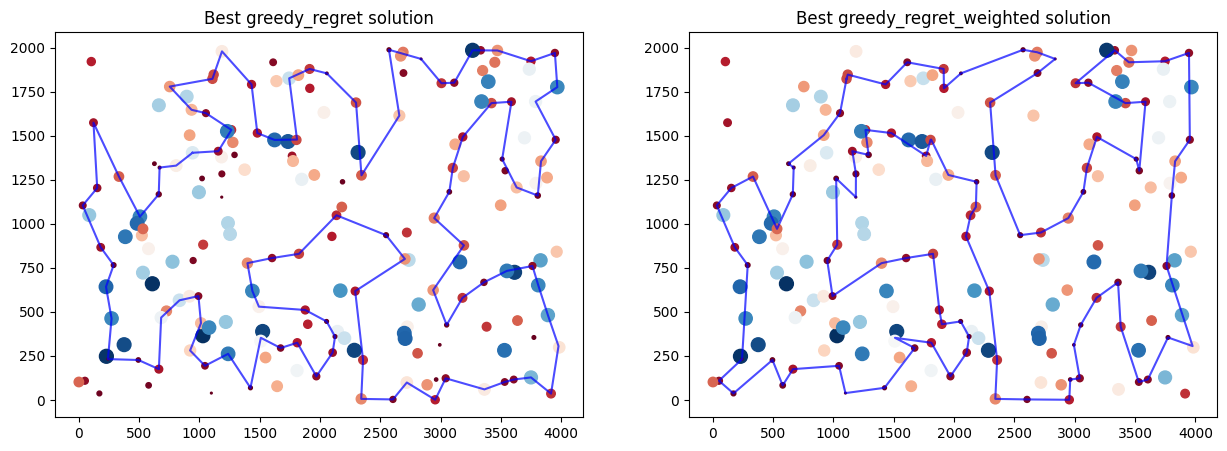

In [224]:
get_solution('TSPA.csv')

Instance: TSPB.csv

greedy_regret results:

Max score: 128550
Average score: 118806.91
Min/Best score: 109774
Selected Nodes: [ 75 163 118 172  22 106  16  14   8  40 115  30  32  96 149  53  84 195
 139 107  12 109 104 193  71 124 150 117 196  60  21 142 141 188  83  91
 156  78  67 114  72  58  89 159 147 176 187 181 100 170  90 136  73 185
 132  65  18  29 168   6 199 190 198 175  57   0 164  66  27 111 116 102
  37 137  56  80   4  88  68  36 134 154  23 112  94 152 125  93 103  38
  42 101  31 179 197  34  11   5 105   2]

greedy_regret_weighted results:

Max score: 77676
Average score: 71801.35
Min/Best score: 70153
Selected Nodes: [  0  99  43  50  24 127 121 131 103  38  42 101  31 122 143 179 197 183
  34   5 128  66 169 135 198 190  19  95 172 182   2 163  40 115  82  63
   8  14  16  18 132  52  12 107 139 196 142 130 141 148 140 174  91 192
 117 150 158  67 114  72 171  58  89 129 159 147  64  85 166 162  44  71
 193 119  59 109 189 181 170 185  73  61 136  79 145 157  80 1

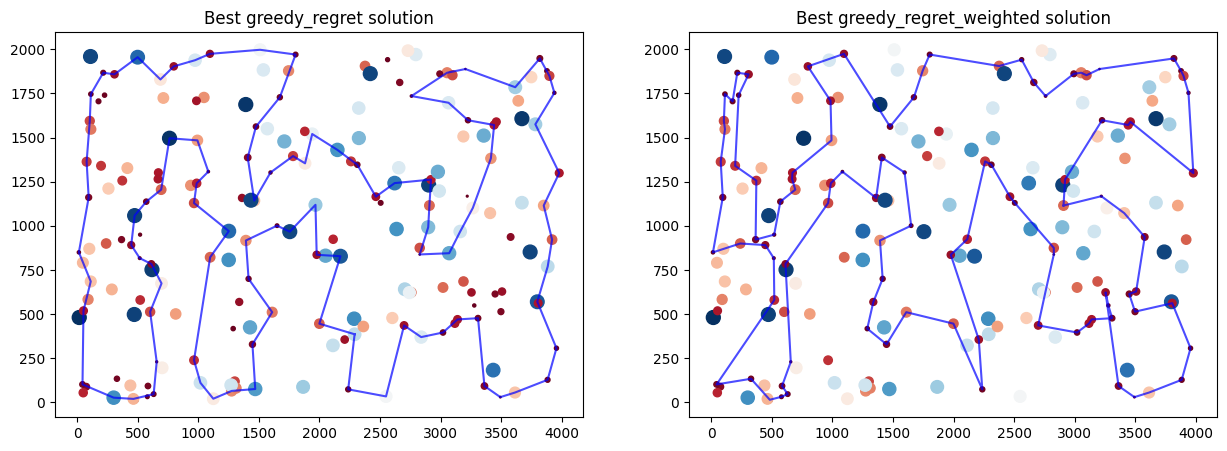

In [229]:
get_solution('TSPB.csv')

Instance: TSPC.csv

greedy_regret results:

Max score: 73090
Average score: 69013.725
Min/Best score: 65095
Selected Nodes: [ 36  54  55  22  53 108 171 104  79  44 144 141  24   6 156  98 190  72
 122  89  73  31 197  14 168  80 124   8 110 169 196  51  45 186 127 153
 175 167 101  60  17 126 134 119 100  13  52 148 106 160 162  11 152 188
   1 177 137  39 199 150 192 187  29  77  43  50 149   0  19  58 164  65
 128  84  37 159  59  96  46  82 185  64  20  71  61 183 103   7 146  93
 155  47 138 163 113 142  25  85  10 132]

greedy_regret_weighted results:

Max score: 58288
Average score: 55946.205
Min/Best score: 54126
Selected Nodes: [ 21 194  79  67  87 102 144 141   6 172 156  98  94  42  89  12  73  31
  95 169 139   8  26  92  48  11 152 130  75 189 109 119 134  99 135  51
 112  72 190  66  68  24  45 186 127  88 153 161  76 145  49   0 115  69
 149  50 121  91 114   4  77  43  86  35  19 178 164  34  40 128 132  36
  54  55 195  22  18  53 117  15 108  62 155  47 138 113  74 16

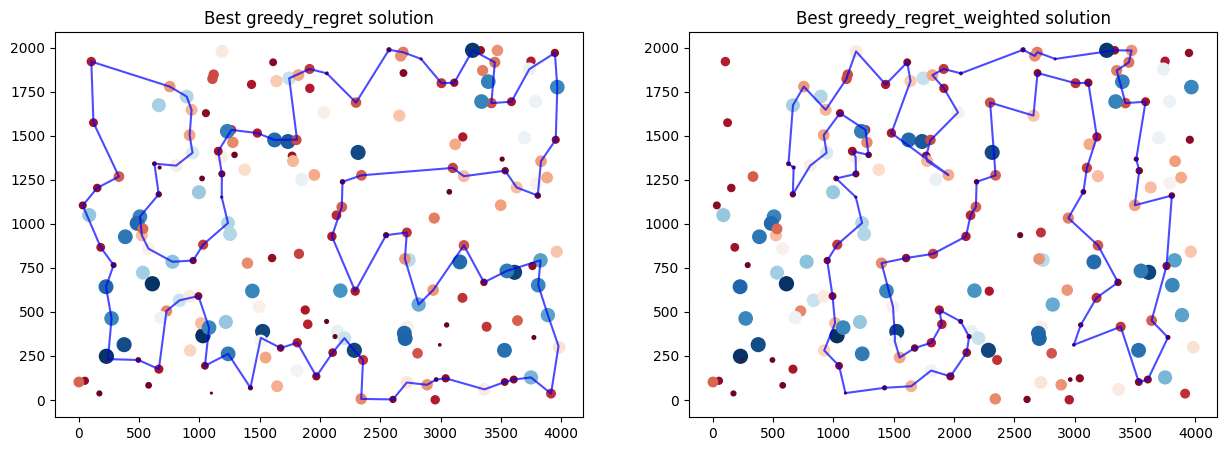

In [230]:
get_solution('TSPC.csv')

Instance: TSPD.csv

greedy_regret results:

Max score: 74903
Average score: 70442.125
Min/Best score: 64682
Selected Nodes: [166 110  85  72 171  89  35 147 176 187 181 100 170  90 136  73  81 132
  12 173  14  16 106 172  95  22  29   6 199  19 120  86  79 145 157 160
 153  88 137  41  37 123 194  25 154  23 112  94 152 125  93 103  38  42
 101  31 183 122  24  50  43 116  99  62  46   0 164  66 128 167 133 182
   2  48  40   8  63  82  32  96 149  53 138  60  21 142 141 188 174  91
 156   3  78  45 126 158 162 150  44  71]

greedy_regret_weighted results:

Max score: 59416
Average score: 53691.48
Min/Best score: 49165
Selected Nodes: [ 95 163 182   2 133 167   5  11  34 183 197 179 121  24 127 143 122  92
  26 128  66 169   0  99  57 146 137  37 165 154  25  36  88  55   4 153
  80 157 145  79  86 135 198 190  19  33  29  18  73 185 132  12 107  97
 139 193  59 119  71  44 162 150 117 196  60 192  21 155 158 114 126  67
  45  78   3 156  91  70  51 174 161 130 188 140 148 141 142  53

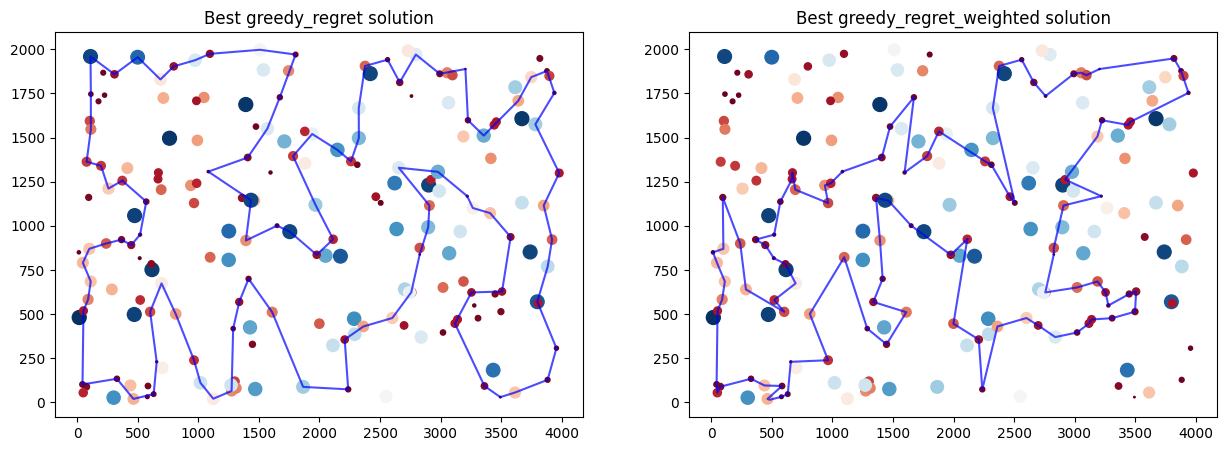

In [231]:
get_solution('TSPD.csv')